In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

4431872/4422102 [==============================] - 0s 0us/step


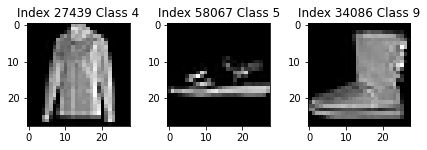

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [ ]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")


# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [ ]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [ ]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, batch_norm = "preact", alpha_mov = 0.8,device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.batch_norm, self.alpha_mov, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, batch_norm, alpha_mov, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1])) #get info about how to initialize
    self.gamma1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2])) #get info about how to initialize
    self.gamma2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3])) #get info about how to initialize
    self.gamma3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    self.epsilon = 1e-7
    self.mov_mean = tf.Variable(0.)
    self.mov_var = tf.Variable(0.)
    self.test_mean = None
    self.test_var = None

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.beta1, self.beta2, self.beta3, self.gamma1, self.gamma2, self.gamma3]
    #self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.beta1, self.gamma1, self.beta2, self.gamma2]
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        if self.batch_norm == "preact":
          self.y = self.compute_output_for_preact(X)
        else:
          self.y = self.compute_output_for_postact(X)
    else:
        if self.batch_norm == "preact":
          self.y = self.compute_output_for_preact(X)
        else:
          self.y = self.compute_output_for_postact(X)
      
    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)

    #print (f"Loss : {loss_x}")
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

  def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)

    #print (f"grads: {grads}")
    optimizer.apply_gradients(zip(grads, self.variables))

  def batch_norm_train(self, Z, beta, gamma):
    # Z : result of pre or post activation
    #Calculating mean and variance
    # if test_mean is None then trigger training logic
    if self.test_mean is not None:
      #print (f"TEST : Moving avg: {self.mov_mean}, Moving variance: {self.mov_var}")
      mean_mini_batch = self.test_mean
      var_mini_batch = self.test_var
    else:
      mean_mini_batch = tf.reduce_mean(Z)
      var_mini_batch = tf.math.reduce_variance(Z)
      self.mov_mean.assign(self.alpha_mov * self.mov_mean + (1 - self.alpha_mov) * mean_mini_batch)
      self.mov_var.assign(self.alpha_mov * self.mov_var + (1 - self.alpha_mov) * var_mini_batch)
    
    Z_hat = tf.divide(tf.subtract(Z, mean_mini_batch), tf.sqrt(tf.add(var_mini_batch, self.epsilon)))
    batch_norm = tf.add(tf.multiply(gamma, Z_hat), beta)

    return batch_norm
  
  #@tf.function
  def compute_output_for_preact(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    z1 = self.batch_norm_train(z1, self.beta1, self.gamma1)
    h1 = tf.nn.relu(z1)
      
    z2 = tf.matmul(h1, self.W2) + self.b2
    z2 = self.batch_norm_train(z2, self.beta2, self.gamma2)
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    z3 = self.batch_norm_train(z3, self.beta3, self.gamma3)
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)
  
  #@tf.function
  def compute_output_for_postact(self, X):
      """
      Custom method to obtain output tensor during forward pass
      """
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      h1 = self.batch_norm_train(h1, self.beta1, self.gamma1)
        
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      h2 = self.batch_norm_train(h2, self.beta2, self.gamma2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      h3 = self.batch_norm_train(h3, self.beta3, self.gamma3)

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
      return (output)

    

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


  def var(self,y_pred):
     """
      Calculate variance 
      """
     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
     std_dev = np.std(y_pred_tf) #Calculates standard deviation
     variance = (std_dev**2) # calculate variance
     return variance 



# Function to train a model

In [ ]:
def train_model(mlp, num_epochs, seed, shuffle_size, batch_size, opti):
  time_start = time.time()
  train_acc_list = []
  val_acc_list = []
  train_cce_list = []
  for epoch in range(num_epochs):
    loss_total = tf.zeros([1,1], dtype=tf.float32)    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(shuffle_size, seed=epoch*(seed)).batch(batch_size)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp.forward(inputs) 
      loss_total = loss_total + mlp.loss(preds, outputs)
      mlp.backward(inputs, outputs, opti)

    preds = mlp.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    train_acc_list.append(ds)
    print('\nTrain Accuracy: {:.4f}'.format(ds))

    avg_cce = np.sum(loss_total) / X_train.shape[0]
    train_cce_list.append(avg_cce)
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, avg_cce))

    # Setting mean and variance for validation set accuracy check
    mlp.test_mean = mlp.mov_mean
    mlp.test_var = mlp.mov_var
    preds_val = mlp.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()
    val_acc_list.append(cur_val_acc)
    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))

    # Setting mean and variance to None for training Batch Norm logic to trigger
    mlp.test_mean = None
    mlp.test_var = None
    #plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')
        
  time_taken = time.time() - time_start
      
  # Validate model
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  return time_taken, train_acc_list, val_acc_list, train_cce_list
  #For per epoch_time = Total_Time / Number_of_epochs

## Function to test a model

In [ ]:
def test_model(model):
# Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)
  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = model.forward(inputs)
    test_loss_total = test_loss_total + model.loss(preds, outputs)
  
  avg_test_loss = np.sum(test_loss_total.numpy()) / X_test.shape[0]
  print('Test loss: {:.4f}'.format(avg_test_loss))

  # Test model
  preds_test = model.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
  return avg_test_loss, cur_test_acc

In [ ]:
NUM_EPOCHS = 10
seed = 5308
shuffle_size = 25
batch_size=128
np.random.seed(seed)
tf.random.set_seed(seed)

## Training - SGD preact

In [ ]:
mlp_preact = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, batch_norm="preact", device='gpu')
opti = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
time_to_train, train_acclist, val_acclist, train_ccelist  = train_model(mlp_preact, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size, opti=opti)


Train Accuracy: 0.8435
Number of Epoch = 1 - Average Cross Entropy:= 0.00437664794921875 

Validation Accuracy: 0.8307

Train Accuracy: 0.8690
Number of Epoch = 2 - Average Cross Entropy:= 0.003115779113769531 

Validation Accuracy: 0.8571

Train Accuracy: 0.8787
Number of Epoch = 3 - Average Cross Entropy:= 0.0027889276123046875 

Validation Accuracy: 0.8606

Train Accuracy: 0.8884
Number of Epoch = 4 - Average Cross Entropy:= 0.00261331298828125 

Validation Accuracy: 0.8700

Train Accuracy: 0.8922
Number of Epoch = 5 - Average Cross Entropy:= 0.002459342041015625 

Validation Accuracy: 0.8721

Train Accuracy: 0.8986
Number of Epoch = 6 - Average Cross Entropy:= 0.002328775634765625 

Validation Accuracy: 0.8790

Train Accuracy: 0.8935
Number of Epoch = 7 - Average Cross Entropy:= 0.002243583221435547 

Validation Accuracy: 0.8737

Train Accuracy: 0.8961
Number of Epoch = 8 - Average Cross Entropy:= 0.002145598297119141 

Validation Accuracy: 0.8765

Train Accuracy: 0.8942
Number of

# Check inference - preact

In [ ]:
#Checking preact
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
mlp_preact.test_mean = mlp_preact.mov_mean
mlp_preact.test_var = mlp_preact.mov_var
test_model(mlp_preact)

Test loss: 0.0004

Test Accuracy: 0.87


(0.0003645068407058716, 0.871)

# Run training - SGD postact

In [ ]:
mlp_postact = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, batch_norm="postact", device='gpu')
opti = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
time_to_train, train_acclist, val_acclist, train_ccelist  = train_model(mlp_postact, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size, opti=opti)


Train Accuracy: 0.8508
Number of Epoch = 1 - Average Cross Entropy:= 0.0042972244262695315 

Validation Accuracy: 0.7970

Train Accuracy: 0.8735
Number of Epoch = 2 - Average Cross Entropy:= 0.0030968853759765626 

Validation Accuracy: 0.8499

Train Accuracy: 0.8851
Number of Epoch = 3 - Average Cross Entropy:= 0.002770556640625 

Validation Accuracy: 0.8577

Train Accuracy: 0.8869
Number of Epoch = 4 - Average Cross Entropy:= 0.0025629177856445313 

Validation Accuracy: 0.8602

Train Accuracy: 0.8957
Number of Epoch = 5 - Average Cross Entropy:= 0.0024008526611328123 

Validation Accuracy: 0.8629

Train Accuracy: 0.9030
Number of Epoch = 6 - Average Cross Entropy:= 0.0022762193298339842 

Validation Accuracy: 0.8739

Train Accuracy: 0.9038
Number of Epoch = 7 - Average Cross Entropy:= 0.0021766017150878906 

Validation Accuracy: 0.8662

Train Accuracy: 0.9037
Number of Epoch = 8 - Average Cross Entropy:= 0.0020636444091796874 

Validation Accuracy: 0.8666

Train Accuracy: 0.8993
Numb

# Inference - Post activation model

In [ ]:
#Checking postact inference
mlp_postact.test_mean = mlp_postact.mov_mean
mlp_postact.test_var = mlp_postact.mov_var
test_model(mlp_postact)

Test loss: 0.0004

Test Accuracy: 0.86


(0.0003953143119812012, 0.8645)

# Saving your model weights or parameters
* It is always advisable to save your model checkpoints every k epochs. Look at Saver object in tensorflow/keras.
* Visualize your model performance using tensorboard.

# Steps to save model weights using pickle
* Save your model(trainable variables), in our case self.variables into a pickle file.
* Load saved file
* Redefine model
* Load weights
* Re-train or test your model


In [ ]:
#
import pickle
variables_old = mlp_preact.variables
with open('weights_preact.pickle', 'wb') as handle:
    pickle.dump(variables_old, handle)

In [ ]:
with open('weights.pickle', 'rb') as handle:
    b = pickle.load(handle)

# Reusing inference code form previous assignment


In [ ]:
# Obtaining inferences for all three models - 10 iteration per model
from tqdm import tqdm
import json
############## Setting values as per dataset ##############
size_input = 784
size_hidden_1 = 128 
size_hidden_2 = 128
side_hidden_3 = 128
size_output = 10 
number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]
print (f"{number_of_test_examples},{number_of_train_examples}")

########################################################
'''
Additional steps done above
1. Reshape to flatten
2. Normalization
3. One hot encoding
'''

#######################################################
#reg_type_list = ["default", "L2", "dropout"]
reg_type_list = ["preact", "postact"]

inference_stats_total_dict = {
    #"custom":{},
    #"Adam":{},
    #"RMSprop":{},
    "SGD":{}
}


NUM_EPOCHS = 10 # reduced to 10 to save overall time
#NUM_EPOCHS = 2
random_seeds = list(np.random.randint(low=1000, high=100000, size=3))
#random_seeds = list(np.random.randint(low=2000, high=4000, size=2))
print (f"Random seeds used in the test : {random_seeds}")
inf_iters = len(random_seeds)
device_type = 'gpu'
shuffle_size = 25
batch_size = 128
#batch_size = 512
learning_rates = {
    "SGD": 0.1,
    #"Adam": 0.001,
    #"RMSprop": 0.001,
    #"custom": 0.001
}


optimizers = learning_rates.keys()

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(256)
opti = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
####################################################

for optimizer in optimizers:
  inference_stats_dict = {
    "preact":{}, 
    "postact": {}, 
  }
  print (f"#####Running trials for optimizer: {optimizer.upper()}#####")
  for reg_type in reg_type_list:
    print (f"## START: Current Model: {reg_type} ##")
    test_cce_list = []
    test_acc_list = []
    cpu_time_list = []
    train_acc_list_dict = {}
    val_acc_list_dict = {}
    train_cce_list_dict = {}

    for iter in tqdm(range(inf_iters)):
      print(f"\n** Inference Iteration: {iter} **")
      cur_seed = random_seeds[iter]
      print (f"\n#Training {reg_type} model, optimizer {optimizer} with seed {cur_seed}#")
      np.random.seed(cur_seed)
      tf.random.set_seed(cur_seed)


      # Model initialization as per regularization type - regularization code triggers only if knob is on
      mlp = MLP(size_input, size_hidden_1, size_hidden_2, side_hidden_3, size_output, batch_norm = reg_type, device=device_type)
      mlp.test_mean = None
      mlp.test_var = None
      cputime, train_acc_list, val_acc_list, train_cce_list = \
                train_model(mlp, NUM_EPOCHS, seed=cur_seed, shuffle_size=shuffle_size, batch_size=batch_size, opti=opti)

      train_acc_list_dict[cur_seed] = train_acc_list
      val_acc_list_dict[cur_seed] = val_acc_list
      train_cce_list_dict[cur_seed] = train_cce_list
      cpu_time_list.append(cputime)

      # Testing the  - Setting test mean and variance to running stats obtained from testing
      mlp.test_mean = mlp.mov_mean
      mlp.test_var = mlp.mov_var
      (cce_test, acc_test) = test_model(mlp)
      print(f"seed: {cur_seed}, Test Cross Entropy loss: {cce_test}, Accuracy: {acc_test}")

      
      test_cce_list.append(cce_test)
      test_acc_list.append(acc_test)

    inference_stats_dict[reg_type]["test_cce_list"] = test_cce_list
    inference_stats_dict[reg_type]["test_acc_list"] = test_acc_list
    inference_stats_dict[reg_type]["cputime_list"] = cpu_time_list
    inference_stats_dict[reg_type]["train_acc_list_dict"] = train_acc_list_dict
    inference_stats_dict[reg_type]["val_acc_list_dict"] = val_acc_list_dict
    inference_stats_dict[reg_type]["train_cce_list_dict"] = train_cce_list_dict

    print (f"## END: Current Model: {reg_type}##")
    print (f"Current inference results: \n{inference_stats_dict}")
  print (f"Inference stat dict for optimizer : {optimizer}: \n{inference_stats_dict}")
  inference_stats_total_dict[optimizer] = inference_stats_dict
  print (f"Current status of dictionary: {inference_stats_total_dict}")
  with open('fmnist_stats_bnorm.json', 'w') as convert_file:
     convert_file.write(json.dumps(str(inference_stats_total_dict)))
  ################################   

10000,50000
Random seeds used in the test : [77001, 52755, 81065]
#####Running trials for optimizer: SGD#####
## START: Current Model: preact ##


  0%|          | 0/3 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training preact model, optimizer SGD with seed 77001#

Train Accuracy: 0.8468
Number of Epoch = 1 - Average Cross Entropy:= 0.004317352294921875 

Validation Accuracy: 0.8427

Train Accuracy: 0.8715
Number of Epoch = 2 - Average Cross Entropy:= 0.0031137924194335935 

Validation Accuracy: 0.8579

Train Accuracy: 0.8831
Number of Epoch = 3 - Average Cross Entropy:= 0.0027720809936523437 

Validation Accuracy: 0.8663

Train Accuracy: 0.8888
Number of Epoch = 4 - Average Cross Entropy:= 0.0025820327758789064 

Validation Accuracy: 0.8721

Train Accuracy: 0.8924
Number of Epoch = 5 - Average Cross Entropy:= 0.0024218844604492187 

Validation Accuracy: 0.8787

Train Accuracy: 0.8922
Number of Epoch = 6 - Average Cross Entropy:= 0.0023418994140625 

Validation Accuracy: 0.8719

Train Accuracy: 0.9010
Number of Epoch = 7 - Average Cross Entropy:= 0.0022235017395019533 

Validation Accuracy: 0.8807

Train Accuracy: 0.8993
Number of Epoch = 8 - Average Cross Entr

 33%|███▎      | 1/3 [01:54<03:48, 114.08s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 77001, Test Cross Entropy loss: 0.0013803061485290528, Accuracy: 0.8744000196456909

** Inference Iteration: 1 **

#Training preact model, optimizer SGD with seed 52755#

Train Accuracy: 0.8339
Number of Epoch = 1 - Average Cross Entropy:= 0.004350304870605469 

Validation Accuracy: 0.8304

Train Accuracy: 0.8626
Number of Epoch = 2 - Average Cross Entropy:= 0.0031148712158203125 

Validation Accuracy: 0.8507

Train Accuracy: 0.8762
Number of Epoch = 3 - Average Cross Entropy:= 0.00279951416015625 

Validation Accuracy: 0.8594

Train Accuracy: 0.8880
Number of Epoch = 4 - Average Cross Entropy:= 0.0025889529418945314 

Validation Accuracy: 0.8697

Train Accuracy: 0.8952
Number of Epoch = 5 - Average Cross Entropy:= 0.0024665768432617185 

Validation Accuracy: 0.8765

Train Accuracy: 0.8980
Number of Epoch = 6 - Average Cross Entropy:= 0.002337578582763672 

Validation Accuracy: 0.8786

Train Accuracy: 0.8969
Number of Epoch = 7 - Average Cro

 67%|██████▋   | 2/3 [03:47<01:53, 113.98s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 52755, Test Cross Entropy loss: 0.0014349761009216308, Accuracy: 0.8730999827384949

** Inference Iteration: 2 **

#Training preact model, optimizer SGD with seed 81065#

Train Accuracy: 0.8457
Number of Epoch = 1 - Average Cross Entropy:= 0.004414635620117188 

Validation Accuracy: 0.8416

Train Accuracy: 0.8732
Number of Epoch = 2 - Average Cross Entropy:= 0.003104010009765625 

Validation Accuracy: 0.8597

Train Accuracy: 0.8793
Number of Epoch = 3 - Average Cross Entropy:= 0.0028212384033203127 

Validation Accuracy: 0.8665

Train Accuracy: 0.8848
Number of Epoch = 4 - Average Cross Entropy:= 0.0026139642333984376 

Validation Accuracy: 0.8681

Train Accuracy: 0.8921
Number of Epoch = 5 - Average Cross Entropy:= 0.0024749552917480468 

Validation Accuracy: 0.8747

Train Accuracy: 0.8987
Number of Epoch = 6 - Average Cross Entropy:= 0.0023675563049316405 

Validation Accuracy: 0.8763

Train Accuracy: 0.9009
Number of Epoch = 7 - Average C

100%|██████████| 3/3 [05:41<00:00, 113.91s/it]


Test loss: 0.0014

Test Accuracy: 0.87
seed: 81065, Test Cross Entropy loss: 0.0014285715103149414, Accuracy: 0.8680999875068665
## END: Current Model: preact##
Current inference results: 
{'preact': {'test_cce_list': [0.0013803061485290528, 0.0014349761009216308, 0.0014285715103149414], 'test_acc_list': [0.8744, 0.8731, 0.8681], 'cputime_list': [113.8013436794281, 113.61838626861572, 113.44157814979553], 'train_acc_list_dict': {77001: [0.8468199968338013, 0.8715000152587891, 0.8831400275230408, 0.8888400197029114, 0.8923799991607666, 0.8921599984169006, 0.9009600281715393, 0.8993200063705444, 0.8999800086021423, 0.909280002117157], 52755: [0.833899974822998, 0.8626199960708618, 0.8762000203132629, 0.8879799842834473, 0.8952000141143799, 0.8979799747467041, 0.8968799710273743, 0.8976799845695496, 0.8931599855422974, 0.9022799730300903], 81065: [0.8457199931144714, 0.8731600046157837, 0.8792999982833862, 0.8847799897193909, 0.8920999765396118, 0.8986999988555908, 0.9008600115776062, 0.8

  0%|          | 0/3 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training postact model, optimizer SGD with seed 77001#

Train Accuracy: 0.8405
Number of Epoch = 1 - Average Cross Entropy:= 0.00470559814453125 

Validation Accuracy: 0.7907

Train Accuracy: 0.8661
Number of Epoch = 2 - Average Cross Entropy:= 0.0031426089477539065 

Validation Accuracy: 0.8252

Train Accuracy: 0.8764
Number of Epoch = 3 - Average Cross Entropy:= 0.0028356143188476564 

Validation Accuracy: 0.8440

Train Accuracy: 0.8823
Number of Epoch = 4 - Average Cross Entropy:= 0.002629926452636719 

Validation Accuracy: 0.8547

Train Accuracy: 0.8925
Number of Epoch = 5 - Average Cross Entropy:= 0.002500733184814453 

Validation Accuracy: 0.8673

Train Accuracy: 0.8939
Number of Epoch = 6 - Average Cross Entropy:= 0.0023918373107910157 

Validation Accuracy: 0.8680

Train Accuracy: 0.8962
Number of Epoch = 7 - Average Cross Entropy:= 0.002278388366699219 

Validation Accuracy: 0.8665

Train Accuracy: 0.9014
Number of Epoch = 8 - Average Cross Entr

 33%|███▎      | 1/3 [01:53<03:46, 113.42s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 77001, Test Cross Entropy loss: 0.0014517539978027344, Accuracy: 0.8695999979972839

** Inference Iteration: 1 **

#Training postact model, optimizer SGD with seed 52755#

Train Accuracy: 0.8472
Number of Epoch = 1 - Average Cross Entropy:= 0.00434407958984375 

Validation Accuracy: 0.8137

Train Accuracy: 0.8681
Number of Epoch = 2 - Average Cross Entropy:= 0.00311839111328125 

Validation Accuracy: 0.8410

Train Accuracy: 0.8826
Number of Epoch = 3 - Average Cross Entropy:= 0.0028050027465820315 

Validation Accuracy: 0.8547

Train Accuracy: 0.8898
Number of Epoch = 4 - Average Cross Entropy:= 0.002594745178222656 

Validation Accuracy: 0.8622

Train Accuracy: 0.8894
Number of Epoch = 5 - Average Cross Entropy:= 0.0024711099243164064 

Validation Accuracy: 0.8578

Train Accuracy: 0.8967
Number of Epoch = 6 - Average Cross Entropy:= 0.0023571014404296874 

Validation Accuracy: 0.8675

Train Accuracy: 0.8994
Number of Epoch = 7 - Average Cro

 67%|██████▋   | 2/3 [03:46<01:53, 113.29s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 52755, Test Cross Entropy loss: 0.0015488698959350586, Accuracy: 0.8641999959945679

** Inference Iteration: 2 **

#Training postact model, optimizer SGD with seed 81065#

Train Accuracy: 0.8521
Number of Epoch = 1 - Average Cross Entropy:= 0.004507053527832031 

Validation Accuracy: 0.7941

Train Accuracy: 0.8741
Number of Epoch = 2 - Average Cross Entropy:= 0.0031397256469726563 

Validation Accuracy: 0.8209

Train Accuracy: 0.8789
Number of Epoch = 3 - Average Cross Entropy:= 0.0028085311889648437 

Validation Accuracy: 0.8268

Train Accuracy: 0.8889
Number of Epoch = 4 - Average Cross Entropy:= 0.0026214443969726563 

Validation Accuracy: 0.8479

Train Accuracy: 0.8895
Number of Epoch = 5 - Average Cross Entropy:= 0.002468592529296875 

Validation Accuracy: 0.8454

Train Accuracy: 0.8960
Number of Epoch = 6 - Average Cross Entropy:= 0.002346569061279297 

Validation Accuracy: 0.8562

Train Accuracy: 0.8973
Number of Epoch = 7 - Average C

100%|██████████| 3/3 [05:40<00:00, 113.37s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 81065, Test Cross Entropy loss: 0.0015667022705078124, Accuracy: 0.8622000217437744
## END: Current Model: postact##
Current inference results: 
{'preact': {'test_cce_list': [0.0013803061485290528, 0.0014349761009216308, 0.0014285715103149414], 'test_acc_list': [0.8744, 0.8731, 0.8681], 'cputime_list': [113.8013436794281, 113.61838626861572, 113.44157814979553], 'train_acc_list_dict': {77001: [0.8468199968338013, 0.8715000152587891, 0.8831400275230408, 0.8888400197029114, 0.8923799991607666, 0.8921599984169006, 0.9009600281715393, 0.8993200063705444, 0.8999800086021423, 0.909280002117157], 52755: [0.833899974822998, 0.8626199960708618, 0.8762000203132629, 0.8879799842834473, 0.8952000141143799, 0.8979799747467041, 0.8968799710273743, 0.8976799845695496, 0.8931599855422974, 0.9022799730300903], 81065: [0.8457199931144714, 0.8731600046157837, 0.8792999982833862, 0.8847799897193909, 0.8920999765396118, 0.8986999988555908, 0.9008600115776062, 0.

# Obtaining inference statistics

In [9]:
# Load the generated JSON for further processing
# Note that I have renamed and uploaded the file due to colab disconnects
import json
import sys
import numpy as np
import pandas as pd
fname = "fmnist_stats_bnorm.json"
with open(fname) as f:
        data = json.load(f)

In [13]:
import matplotlib.pyplot as plt

In [11]:
## Code to fetch CPU times while training and average cpu time across trials
df = pd.DataFrame()

optimizer_list = ["SGD"]
reg_list = ["preact", "postact"]

avg_cputime_dict = {}
for optim in optimizer_list:
  for reg in reg_list:
    key  = f"{optim}_{reg}"
    df[key] = data[optim][reg]["cputime_list"]
    avg_cputime_dict[key + "_avg"] = np.mean(df[key])
print ("##CPU time stats across trials##")
df

##CPU time stats across trials##


,SGD_preact,SGD_postact
0,113.801344,113.142443
1,113.618386,112.915427
2,113.441578,113.206895


In [15]:
print ("#Average CPU time per model#")
df = pd.DataFrame(avg_cputime_dict,index = [0])
print (df.iloc[0])

#Average CPU time per model#
SGD_preact_avg     113.620436
SGD_postact_avg    113.088255
Name: 0, dtype: float64


# Code to obtain average accuracies in test data across trials

In [17]:
df = pd.DataFrame()

optimizer_list = ["SGD"]
reg_list = ["preact", "postact"]

avg_acc_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                df[key] = data[optim][reg]["test_acc_list"]
                avg_acc_dict[key + "_avg"] = np.mean(df[key])
print ("##Accuracy stats across trials##")
print (df)
print("\n\n")

print ("#Average Accuracy per model#")
df = pd.DataFrame(avg_acc_dict,index = [0])
print (df.iloc[0])

##Accuracy stats across trials##
   SGD_preact  SGD_postact
0      0.8744       0.8696
1      0.8731       0.8642
2      0.8681       0.8622



#Average Accuracy per model#
SGD_preact_avg     0.871867
SGD_postact_avg    0.865333
Name: 0, dtype: float64


# average variance in loss(cce) across epochs across seeds for every model training

In [19]:
df = pd.DataFrame()
#seeds =
variance_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                train_cce_list_dict = data[optim][reg]["train_cce_list_dict"]
                avg_cce_list = []
                for seed in train_cce_list_dict.keys():
                        avg_cce_list.append(np.mean(train_cce_list_dict[seed]))
                variance_dict[key] = np.var(avg_cce_list)

print ("#Average Variance in loss across seeds per model#")
df = pd.DataFrame(variance_dict,index = [0])
print (df.iloc[0])

#Average Variance in loss across seeds per model#
SGD_preact     1.194319e-10
SGD_postact    9.581537e-10
Name: 0, dtype: float64
